# Trabalho Prático 2

## Import Bibliotecas

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import MinMaxScaler
#from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

In [14]:
df = pd.read_csv('student-data.csv')  
df['passed'] = df['passed'].map({'yes': 1, 'no': 0})
df


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,no,no,5,5,4,4,5,4,11,0
391,MS,M,17,U,LE3,T,3,1,services,services,...,yes,no,2,4,5,3,4,2,3,1
392,MS,M,21,R,GT3,T,1,1,other,other,...,no,no,5,5,3,3,3,3,3,0
393,MS,M,18,R,LE3,T,3,2,services,other,...,yes,no,4,4,1,3,4,5,0,1


In [15]:
print(df['passed'].value_counts())

passed
1    265
0    130
Name: count, dtype: int64


## Estatisticas Descritivas Basicas

In [16]:
# Calcula estatísticas descritivas para variáveis numéricas
numeric_df = df.select_dtypes(include=['number'])
mean = numeric_df.mean()
median = numeric_df.median()
std_dev = numeric_df.std()
skewness = numeric_df.skew()
kurtosis = numeric_df.kurt()

# Exibe os resultados
print("Média:\n", mean)
print("\nMediana:\n", median)
print("\nDesvio Padrão:\n", std_dev)
print("\nAssimetria:\n", skewness)
print("\nCurtose:\n", kurtosis)

Média:
 age           16.696203
Medu           2.749367
Fedu           2.521519
traveltime     1.448101
studytime      2.035443
failures       0.334177
famrel         3.944304
freetime       3.235443
goout          3.108861
Dalc           1.481013
Walc           2.291139
health         3.554430
absences       5.708861
passed         0.670886
dtype: float64

Mediana:
 age           17.0
Medu           3.0
Fedu           2.0
traveltime     1.0
studytime      2.0
failures       0.0
famrel         4.0
freetime       3.0
goout          3.0
Dalc           1.0
Walc           2.0
health         4.0
absences       4.0
passed         1.0
dtype: float64

Desvio Padrão:
 age           1.276043
Medu          1.094735
Fedu          1.088201
traveltime    0.697505
studytime     0.839240
failures      0.743651
famrel        0.896659
freetime      0.998862
goout         1.113278
Dalc          0.890741
Walc          1.287897
health        1.390303
absences      8.003096
passed        0.470487
dtype: flo

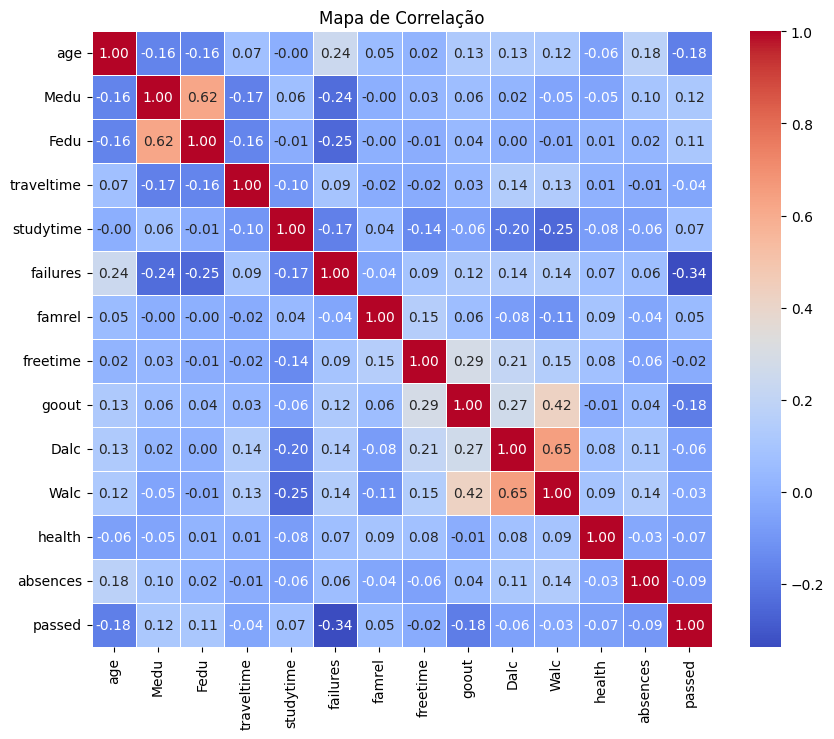

In [17]:
# Calcula a correlação entre as variáveis numéricas e a feature 'passed'
correlation_matrix = numeric_df.corr()

# Faz um mapa de calor para visualizar as correlações
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlação')
plt.show()

In [18]:
from scipy.stats import chi2_contingency

# Seleciona colunas categóricas
categorical_columns = df.select_dtypes(include=['object']).columns

# Conta os valores únicos e exibe os resultados
for col in categorical_columns:
    value_counts = df[col].value_counts()


    # Função para verificar a relação entre variáveis categóricas e a feature 'passed'
    def check_relationship_with_passed(df, categorical_columns):
        for col in categorical_columns:
            contingency_table = pd.crosstab(df[col], df['passed'])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"Relação entre {col} e 'passed':")
            print(f"Chi2: {chi2}, p-valor: {p}")
            if p < 0.1:
                print(f"Há uma relação significativa entre {col} e 'passed' (p < 0.1).\n")
            else:
                print(f"Não há uma relação significativa entre {col} e 'passed' (p >= 0.1).\n")

    # Chama a função para verificar as relações
    check_relationship_with_passed(df, categorical_columns)
    check_relationship_with_passed(df, ['guardian'])


Relação entre school e 'passed':
Chi2: 0.20633910759821295, p-valor: 0.6496520320478856
Não há uma relação significativa entre school e 'passed' (p >= 0.1).

Relação entre sex e 'passed':
Chi2: 1.680311069367968, p-valor: 0.19488312384342535
Não há uma relação significativa entre sex e 'passed' (p >= 0.1).

Relação entre address e 'passed':
Chi2: 0.8288776986104667, p-valor: 0.36259725500729156
Não há uma relação significativa entre address e 'passed' (p >= 0.1).

Relação entre famsize e 'passed':
Chi2: 0.5089949500770806, p-valor: 0.47557425845124546
Não há uma relação significativa entre famsize e 'passed' (p >= 0.1).

Relação entre Pstatus e 'passed':
Chi2: 0.48991628472224347, p-valor: 0.483964650286848
Não há uma relação significativa entre Pstatus e 'passed' (p >= 0.1).

Relação entre Mjob e 'passed':
Chi2: 5.3031673070196845, p-valor: 0.2575805731620897
Não há uma relação significativa entre Mjob e 'passed' (p >= 0.1).

Relação entre Fjob e 'passed':
Chi2: 2.080416181979764, p-v

## Tratamento de Outliers

Número de outliers por coluna:
 age            1
Medu           0
Fedu           2
traveltime     8
studytime     27
failures      83
famrel        26
freetime      19
goout          0
Dalc          18
Walc           0
health         0
absences      15
passed         0
dtype: int64


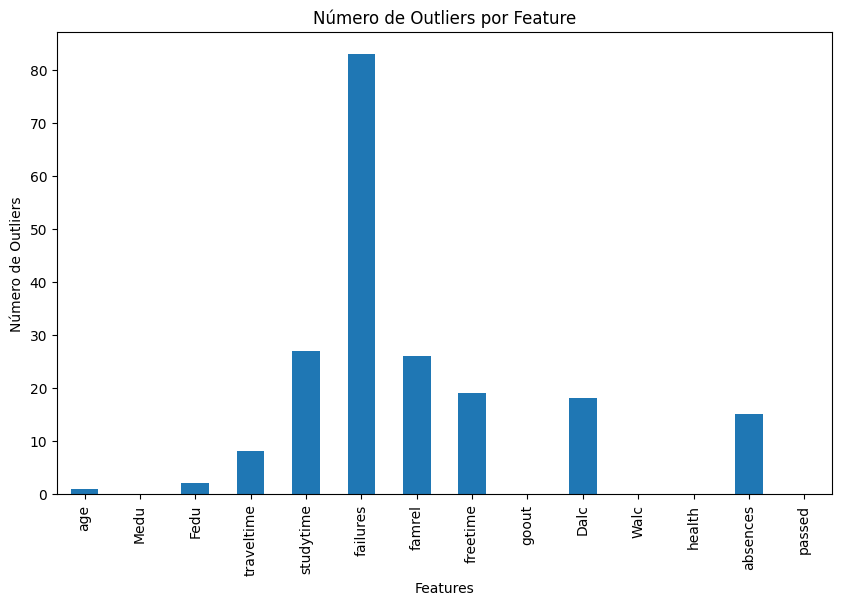

In [19]:
numeric_df = df.select_dtypes(include=['number'])
# Identifica outliers usando o método do IQR
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Assinala os outliers por coluna
outliers = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR)))

# Conta o número de outliers por coluna
outliers_count = outliers.sum()
print("Número de outliers por coluna:\n", outliers_count)


# Faz um gráfico de barras com o número de outliers por feature
outliers_count.plot(kind='bar', figsize=(10, 6), title='Número de Outliers por Feature')
plt.xlabel('Features')
plt.ylabel('Número de Outliers')
plt.show()

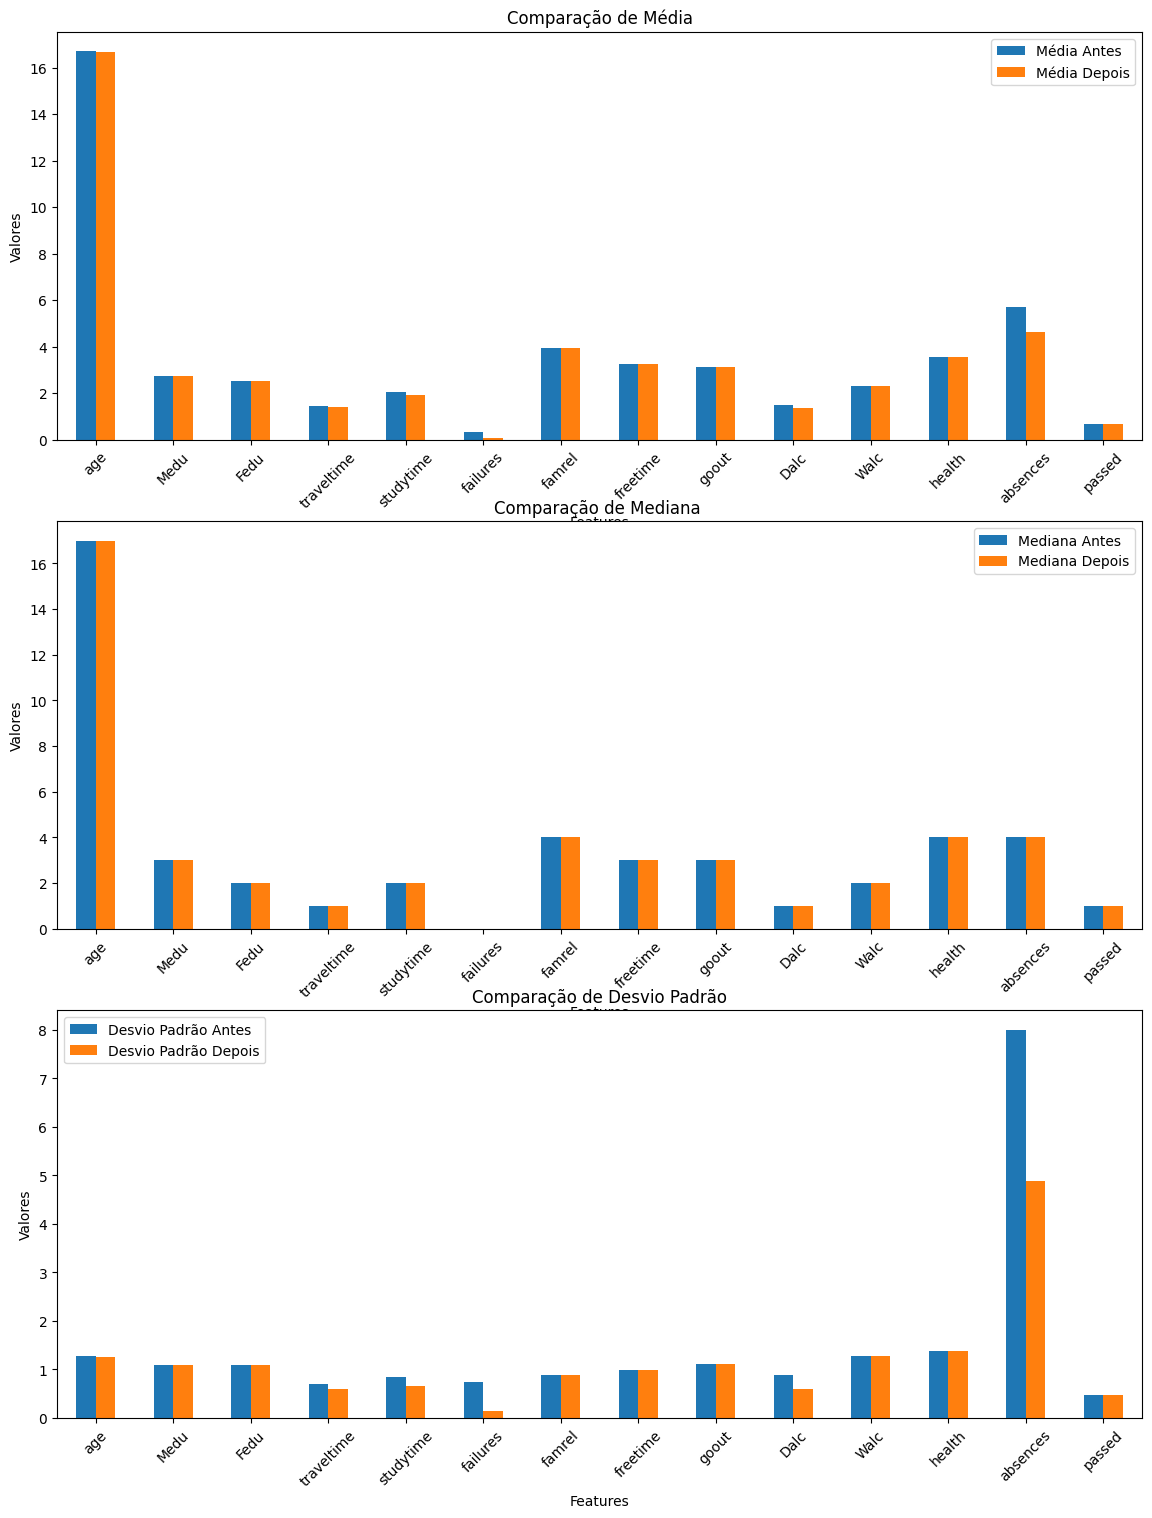

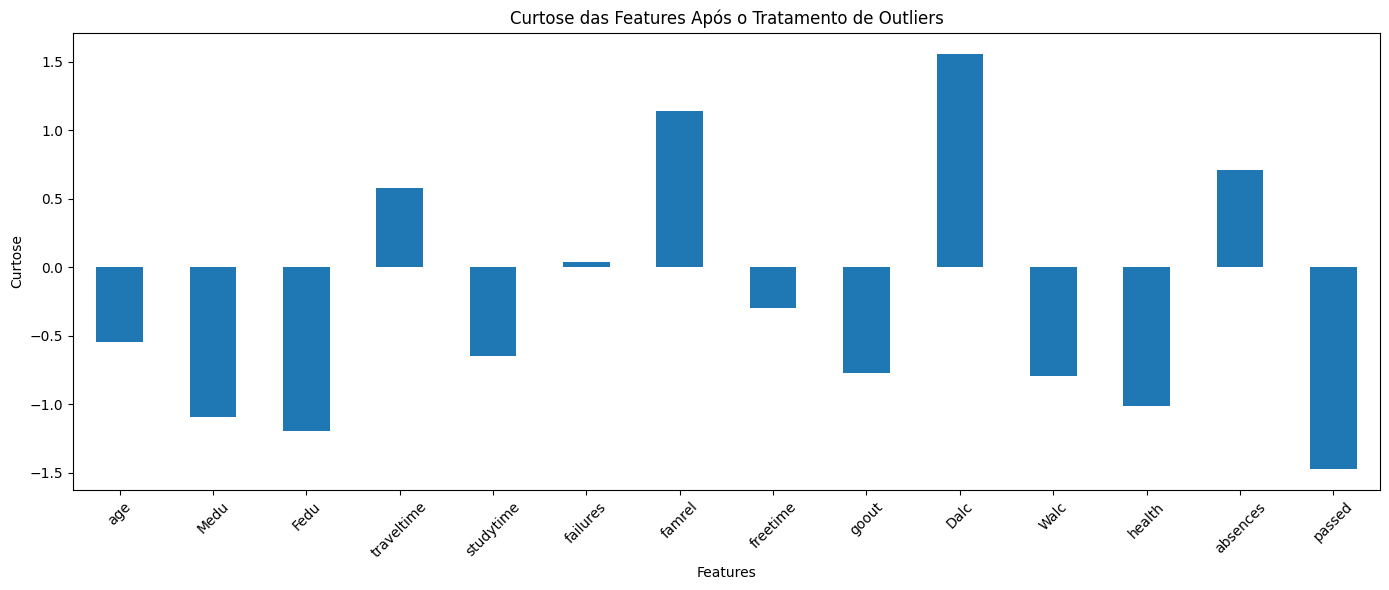

In [20]:
#Substitui os outliers por valores médios
for col in numeric_df.columns:
    # Calcula o limite superior
    upper_bound = Q3[col] + 1.5 * IQR[col]

    # Substitui os valores acima do limite superior pela média
    numeric_df[col] = numeric_df[col].mask(numeric_df[col] > upper_bound, mean[col])

# Recalcula estatísticas descritivas após o tratamento de outliers
mean = numeric_df.mean()
median = numeric_df.median()
std_dev = numeric_df.std()
skewness = numeric_df.skew()
kurtosis = numeric_df.kurt()

# Cria um DataFrame para comparar as estatísticas antes e depois do tratamento de outliers
stats_comparison = pd.DataFrame({
    'Média Antes': df.select_dtypes(include=['number']).mean(),
    'Média Depois': mean,
    'Mediana Antes': df.select_dtypes(include=['number']).median(),
    'Mediana Depois': median,
    'Desvio Padrão Antes': df.select_dtypes(include=['number']).std(),
    'Desvio Padrão Depois': std_dev
})


# Faz um gráfico separado para cada estatística
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Gráfico para a média
stats_comparison[['Média Antes', 'Média Depois']].plot(kind='bar', ax=axes[0], title='Comparação de Média')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Valores')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico para a mediana
stats_comparison[['Mediana Antes', 'Mediana Depois']].plot(kind='bar', ax=axes[1], title='Comparação de Mediana ')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Valores')
axes[1].tick_params(axis='x', rotation=45)

# Gráfico para o desvio padrão
stats_comparison[['Desvio Padrão Antes', 'Desvio Padrão Depois']].plot(kind='bar', ax=axes[2], title='Comparação de Desvio Padrão')
axes[2].set_xlabel('Features')
axes[2].set_ylabel('Valores')
axes[2].tick_params(axis='x', rotation=45)

# Gráfico para a curtose
fig, ax = plt.subplots(figsize=(14, 6))
kurtosis.plot(kind='bar', ax=ax, title='Curtose das Features Após o Tratamento de Outliers')
ax.set_xlabel('Features')
ax.set_ylabel('Curtose')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show() 

# Algoritmos

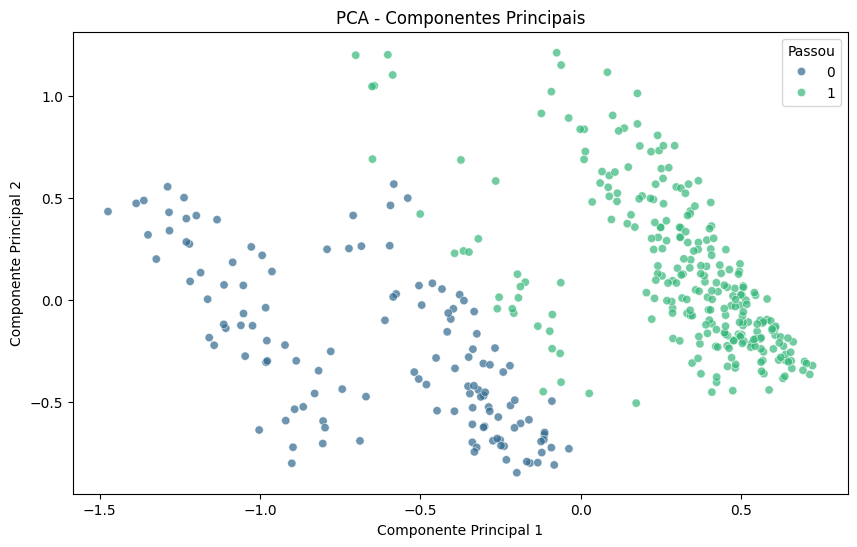

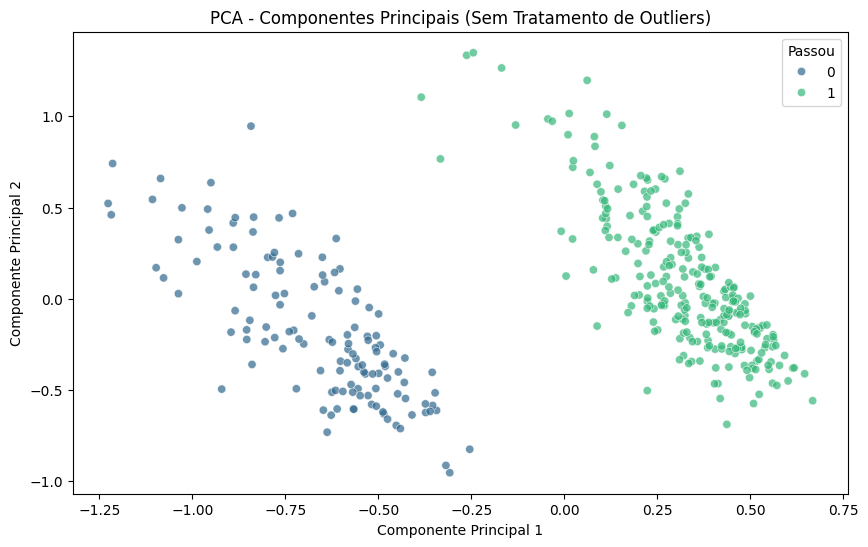

In [21]:
from sklearn.decomposition import PCA

# Normaliza os dados numéricos para a análise PCA
scaler = MinMaxScaler()
numeric_scaled = scaler.fit_transform(numeric_df)

# Aplica o PCA
pca = PCA(n_components=2)  # Reduzindo para 2 componentes principais
pca_result = pca.fit_transform(numeric_scaled)

# Cria um DataFrame com os resultados do PCA
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Adiciona a coluna 'passed' para análise
pca_df['passed'] = df['passed']

# Visualiza os resultados do PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='passed', palette='viridis', alpha=0.7)
plt.title('PCA - Componentes Principais')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Passou')
plt.show()

# Aplica o PCA sem o tratamento de outliers
pca_no_outliers = PCA(n_components=2)
pca_result_no_outliers = pca_no_outliers.fit_transform(scaler.fit_transform(df.select_dtypes(include=['number'])))

# Cria um DataFrame com os resultados do PCA sem tratamento de outliers
pca_df_no_outliers = pd.DataFrame(data=pca_result_no_outliers, columns=['PC1', 'PC2'])
pca_df_no_outliers['passed'] = df['passed']

# Visualiza os resultados do PCA sem tratamento de outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df_no_outliers, x='PC1', y='PC2', hue='passed', palette='viridis', alpha=0.7)
plt.title('PCA - Componentes Principais (Sem Tratamento de Outliers)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Passou')
plt.show()